In [16]:
!pip install torchsummary

In [80]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv, GraphConv
from torch.nn.utils.parametrizations import weight_norm
from torch_geometric.nn import ChebConv
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report

import random
import glob
import os
import json
import pickle

import warnings
warnings.filterwarnings("ignore")

# Model

In [18]:
class TemporalConv(nn.Module):

    """
    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        kernel_size (int): Convolutional kernel size.
    """

    def __init__(self, in_channels: int, out_channels: int, kernel_size, stride: int, padding: int):
        super(TemporalConv, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), (1, stride), (0,padding))
        self.conv_2 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), (1, stride), (0,padding))
        self.conv_3 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), (1, stride), (0,padding))

    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        """Forward pass through temporal convolution block.

        Arg types:
            * **X** (torch.FloatTensor) -  Input data of shape
                (batch_size, input_time_steps, num_nodes, in_channels).

        Return types:
            * **H** (torch.FloatTensor) - Output data of shape
                (batch_size, in_channels, num_nodes, input_time_steps).
        """
        X = X.permute(0, 3, 2, 1)
        P = self.conv_1(X)
        Q = torch.sigmoid(self.conv_2(X))
        PQ = P * Q
        H = F.relu(PQ + self.conv_3(X))
        H = H.permute(0, 3, 2, 1)
        return H

class TemporalDeConv1(nn.Module):

    """
    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        kernel_size (int): Convolutional kernel size.
    """

    def __init__(self, in_channels: int, out_channels: int, kernel_size, stride: int, padding: int):
        super(TemporalDeConv1, self).__init__()
        self.conv_1 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size), (1, stride), (0,padding))
        self.conv_2 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size),(1, stride), (0,padding))
        self.conv_3 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size),(1, stride), (0,padding))

    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        """Forward pass through temporal convolution block.

        Arg types:
            * **X** (torch.FloatTensor) -  Input data of shape
                (batch_size, input_time_steps, num_nodes, in_channels).

        Return types:
            * **H** (torch.FloatTensor) - Output data of shape
                (batch_size, in_channels, num_nodes, input_time_steps).
        """
        X = X.permute(0, 3, 2, 1)
        P = self.conv_1(X)
        Q = torch.sigmoid(self.conv_2(X))
        PQ = P * Q
        H = F.relu(PQ + self.conv_3(X))
        H = H.permute(0, 3, 2, 1)
        return H

class TemporalDeConv2(nn.Module):

    """
    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        kernel_size (int): Convolutional kernel size.
    """

    def __init__(self, in_channels: int, out_channels: int, kernel_size, stride: int):
        super(TemporalDeConv2, self).__init__()
        self.conv_1 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size),(1, stride))
        self.conv_2 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size),(1, stride))
        self.conv_3 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size),(1, stride))

    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        """Forward pass through temporal convolution block.

        Arg types:
            * **X** (torch.FloatTensor) -  Input data of shape
                (batch_size, input_time_steps, num_nodes, in_channels).

        Return types:
            * **H** (torch.FloatTensor) - Output data of shape
                (batch_size, in_channels, num_nodes, input_time_steps).
        """
        X = X.permute(0, 3, 2, 1)
        P = self.conv_1(X)
        Q = torch.sigmoid(self.conv_2(X))
        PQ = P * Q
        H = F.relu(PQ + self.conv_3(X))
        H = H.permute(0, 3, 2, 1)
        return H


In [19]:
class STConvEncoder(nn.Module):

    def __init__(
        self,
        num_nodes: int,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int,
        padding: int,
        K: int,
        normalization: str = "sym",
        bias: bool = True,
    ):
        super(STConvEncoder, self).__init__()
        self.num_nodes = num_nodes
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.K = K
        self.normalization = normalization
        self.bias = bias

        self._temporal_conv1 = TemporalConv(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size, stride = stride, padding = padding,
        )

        self._graph_conv = ChebConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels,
            K=K,
            normalization=normalization,
            bias=bias,
        )

        self._temporal_conv2 = TemporalConv(
            in_channels=hidden_channels,
            out_channels=out_channels,
            kernel_size=kernel_size, stride = stride, padding = padding,
        )

        self._batch_norm = nn.BatchNorm2d(num_nodes)

    def forward(self, X: torch.FloatTensor, edge_index: torch.LongTensor, edge_weight: torch.FloatTensor = None,) -> torch.FloatTensor:

        r"""Forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph.

        Arg types:
            * **X** (PyTorch FloatTensor) - Sequence of node features of shape (Batch size X Input time steps X Num nodes X In channels).
            * **edge_index** (PyTorch LongTensor) - Graph edge indices.
            * **edge_weight** (PyTorch LongTensor, optional)- Edge weight vector.

        Return types:
            * **T** (PyTorch FloatTensor) - Sequence of node features.
        """
        #print(X.shape)
        T_0 = self._temporal_conv1(X)
        #print(T_0.shape)
        T = torch.zeros_like(T_0).to(T_0.device)
        for b in range(T_0.size(0)):
            for t in range(T_0.size(1)):
                T[b][t] = self._graph_conv(T_0[b][t], edge_index, edge_weight)

        T = F.relu(T)
        #print(T.shape)
        T = self._temporal_conv2(T)
        #print(T.shape)
        # T = T.permute(0, 2, 1, 3)
        # #print(T.shape)
        # T = self._batch_norm(T)
        # T = T.permute(0, 2, 1, 3)
        #print(T.shape)

        return T

In [20]:
class STConvDecoder(nn.Module):

    def __init__(
        self,
        num_nodes: int,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        kernel_size: int,
        kernel_size_de: int,
        stride: int,
        padding: int,
        K: int,
        normalization: str = "sym",
        bias: bool = True,
    ):
        super(STConvDecoder, self).__init__()
        self.num_nodes = num_nodes
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.K = K
        self.normalization = normalization
        self.bias = bias

        self._temporal_conv1 = TemporalDeConv1(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size, stride = stride, padding = padding,
        )

        self._graph_conv = ChebConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels,
            K=K,
            normalization=normalization,
            bias=bias,
        )

        self._temporal_conv2 = TemporalDeConv2(
            in_channels=hidden_channels,
            out_channels=out_channels,
            kernel_size=kernel_size_de, stride = stride,
        )

        self._batch_norm = nn.BatchNorm2d(num_nodes)

    def forward(self, X: torch.FloatTensor, edge_index: torch.LongTensor, edge_weight: torch.FloatTensor = None,) -> torch.FloatTensor:

        r"""Forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph.

        Arg types:
            * **X** (PyTorch FloatTensor) - Sequence of node features of shape (Batch size X Input time steps X Num nodes X In channels).
            * **edge_index** (PyTorch LongTensor) - Graph edge indices.
            * **edge_weight** (PyTorch LongTensor, optional)- Edge weight vector.

        Return types:
            * **T** (PyTorch FloatTensor) - Sequence of node features.
        """
        T_0 = self._temporal_conv1(X)
        T = torch.zeros_like(T_0).to(T_0.device)
        for b in range(T_0.size(0)):
            for t in range(T_0.size(1)):
                T[b][t] = self._graph_conv(T_0[b][t], edge_index, edge_weight)

        T = F.relu(T)
        T = self._temporal_conv2(T)
        # T = T.permute(0, 2, 1, 3)
        # T = self._batch_norm(T)
        # T = T.permute(0, 2, 1, 3)
        return T

In [21]:
# a specified number of STConv blocks, followed by an output layer
class STConvAE(torch.nn.Module):
    def __init__(self, device, num_nodes, channel_size_list, num_layers, 
                 kernel_size, K, window_size, kernel_size_de, stride, padding,\
                 normalization = 'sym', bias = True):
    # num_nodes = number of nodes in the input graph
    # channel_size_list =  2d array representing feature dimensions throughout the model
    # num_layers = number of STConv blocks
    # kernel_size = length of the temporal kernel
    # K = size of the chebyshev filter for the spatial convolution
    # window_size = number of historical time steps to consider

        super(STConvAE, self).__init__()
        self.layers = nn.ModuleList([])
        # add STConv blocks
        for l in range(num_layers):
            input_size, hidden_size, output_size = channel_size_list[l][0], channel_size_list[l][1], channel_size_list[l][2]
            if l==0:
                self.layers.append(STConvEncoder(num_nodes, input_size, hidden_size, output_size, kernel_size, stride, padding, K, normalization, bias))
            if l==1:
                self.layers.append(STConvDecoder(num_nodes, input_size, hidden_size, output_size, kernel_size, kernel_size_de, stride, padding, K, normalization, bias))
        

        # # add output layer
        # self.layers.append(OutputLayer(channel_size_list[-1][-1], \
        #                                window_size - 2 * num_layers * (kernel_size - 1), \
        #                                num_nodes))
        # CUDA if available
        for layer in self.layers:
            layer = layer.to(device)

    def forward(self, x, edge_index, edge_weight ):
        #print(x.shape)
        for layer in self.layers:
            x = layer(x, edge_index, edge_weight)
          #print(x.shape)
        # out_layer = self.layers[-1]
        # x = x.permute(0, 3, 1, 2)
        # x = out_layer(x)
        # print(x.shape)
        return x

# Simple model

In [22]:
VERBOSE = False

In [23]:
class SimpleTemporalConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(SimpleTemporalConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), stride=(1, stride), padding=(0, padding))
        self.conv2 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), stride=(1, stride), padding=(0, padding))
        self.conv3 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), stride=(1, stride), padding=(0, padding))

    def forward(self, x):


        x = x.permute(0, 3, 2, 1)  # (B, T, N, C) -> (B, C, N, T)
        
        P = self.conv1(x)
        Q = torch.sigmoid(self.conv2(x))
        PQ = P * Q
        x = F.relu(PQ + self.conv3(x))

        x=x.permute(0, 3, 2, 1)  # Back to (B, T, N, C)
        
        return x
    
    
    
class SimpleTemporalDeConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(SimpleTemporalDeConv, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size), stride=(1, stride), padding=(0, padding))
        self.deconv2 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size), stride=(1, stride), padding=(0, padding))
        self.deconv3 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size), stride=(1, stride), padding=(0, padding))

    def forward(self, x):
        if VERBOSE: print("Temporal DeConv")
        
        x = x.permute(0, 3, 2, 1)  # (B, T, N, C) -> (B, C, N, T)
        
        P = self.deconv1(x)
        Q = torch.sigmoid(self.deconv2(x))
        PQ = P * Q
        x = F.relu(PQ + self.deconv3(x))
        
        x=x.permute(0, 3, 2, 1) # Back to (B, T, N, C)
        
        return x 


In [24]:
class SimpleSpatialConv(nn.Module):
    def __init__(self, in_channels, out_channels, K, normalization='sym', bias=False):
        super(SimpleSpatialConv, self).__init__()
        self.conv = ChebConv(in_channels, out_channels, K, normalization=normalization, bias=bias)

    def forward(self, x, edge_index, edge_weight):
        if VERBOSE: print("Spatial")
        
        if VERBOSE: print(x.shape)
        batch_size, time_steps, num_nodes, _ = x.size()
        output= torch.zeros([batch_size, time_steps, num_nodes, self.conv.out_channels]).to(x.device)

        for t in range(x.size(1)):
            output[:, t] = F.relu(self.conv(x[:, t], edge_index, edge_weight))
        
        if VERBOSE: print(output.shape)
        return output

In [25]:
class SimpleEncoder(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels , kernel_size, stride, padding, K):
        super(SimpleEncoder, self).__init__()
        self.temporal_conv = SimpleTemporalConv(input_channels, input_channels, kernel_size, stride, padding)
        self.graph_conv = SimpleSpatialConv(input_channels, hidden_channels, K)
        self.temporal_conv_2 = SimpleTemporalConv(hidden_channels, output_channels, kernel_size, stride, padding)
        
    def forward(self, x, edge_index, edge_weight=None):
        x = self.temporal_conv(x)
        x = self.graph_conv(x, edge_index, edge_weight)
        x = self.temporal_conv_2(x)
        return x
        

class SimpleDecoder(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, kernel_size, stride, padding, K):    
        super(SimpleDecoder, self).__init__()
        self.temporal_deconv = SimpleTemporalDeConv(input_channels, hidden_channels, kernel_size, stride, padding)
        self.graph_deconv = SimpleSpatialConv(hidden_channels, output_channels, K)
        self.temporal_deconv_2 = SimpleTemporalDeConv(output_channels, output_channels, kernel_size, stride, padding)
        
    def forward(self, x, edge_index, edge_weight=None):
        x = self.temporal_deconv(x)
        x = self.graph_deconv(x, edge_index, edge_weight)
        x = self.temporal_deconv_2(x)
        return x
        

In [26]:
class SimpleSTConvAE(nn.Module):
    def __init__(self, device, channel_size_list, num_layers, 
                 kernel_size, K, stride, padding,\
                 normalization = 'sym' , bias = True):
        
        super(SimpleSTConvAE, self).__init__()
        self.layers = nn.ModuleList([])
        # add STConv blocks
        for l in range(num_layers):
            input_size, hidden_size, output_size = channel_size_list[l][0], channel_size_list[l][1], channel_size_list[l][2]
            if l==0:
                self.layers.append(SimpleEncoder(input_size, hidden_size, output_size, kernel_size, stride, padding, K))
            if l==1:
                self.layers.append(SimpleDecoder(input_size, hidden_size, output_size, kernel_size, stride, padding, K))
                
        for layer in self.layers:
            layer = layer.to(device)
            
    def forward(self, x, edge_index, edge_weight=None):
        
        for layer in self.layers:
            x = layer(x, edge_index, edge_weight)
        return x
    
    


# Data preparation

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
DATA_PATH = 'data/subdata'
STARTING_MODEL_PATH = None

FOLDER_MODEL_SAVE = f'sandwich_model_with_gate'
# os.makedirs(FOLDER_MODEL_SAVE)

In [29]:
TRAIN_RATIO = 0.7  # Training ratio
VAL_RATIO = 0.15  # Validation ratio
TEST_RATIO = 0.15  # Test ratio

TRAIN_BATCH_SIZE = 2  # Batch size training
VAL_BATCH_SIZE = 2  # Batch size validation
TEST_BATCH_SIZE = 1  # Batch size test

TIME_STEPS = 16  # Number of time steps (DAYS)

In [30]:
# Input [batch_size, time_steps, num_nodes, num_features]
def load_data(FOLDER, CORRUPT_FOLDER=None, CORRUPT_PROB=0.0):
    file_paths = glob.glob(f'{FOLDER}/node_features_*.pt')  # Percorso per tutti i file CSV
    num_files = len(file_paths)
    step = 1  # Offset per la finestra scorrevole

    # Carica tutti i file in una lista
    all_data = [torch.load(file_path) for file_path in file_paths]  # Ogni file è (num_nodes, num_features)

    if CORRUPT_FOLDER:
        indices = np.zeros(len(all_data))
        corrupt_file_paths = glob.glob(f'{CORRUPT_FOLDER}/node_features_*.pt')
        corrupt_data = [torch.load(file_path) for file_path in corrupt_file_paths]
        for i in range(len(all_data)):
            if random.random() < CORRUPT_PROB:
                all_data[i] = corrupt_data[i]
                indices[i] = 1

    # Numero di nodi e feature dai dati
    num_nodes, num_features = all_data[0].shape

    # Crea le finestre temporali
    windows = []
    indices_stacked = []
    for i in range(0, num_files - TIME_STEPS + 1, step):
        window = torch.stack(all_data[i:i + TIME_STEPS], dim=0)  # Raggruppa 10 giorni
        windows.append(window)

        if CORRUPT_FOLDER:
            indices_stacked.append(int(indices[i:i + TIME_STEPS].sum()))

    # Concatena le finestre temporali
    data = torch.stack(windows, dim=0)

    if CORRUPT_FOLDER:
        return data, indices_stacked

    return data, num_nodes, num_features


In [31]:
data, num_nodes, num_features= load_data(DATA_PATH)

/tmp/ipykernel_4059456/2839598384.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_data = [torch.load(file_path) for file_path in file_paths]  # Ogni file è (num_node

In [32]:
edge_index = torch.load('node_connections/edge_index.pt').to(device)
edge_index.shape

/tmp/ipykernel_4059456/2695016871.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  edge_index = torch.load('node_connections/edge_index.pt').to(device)


torch.Size([2, 12564])

In [33]:
# Create train, validation and test sets
train_data = data[:int(TRAIN_RATIO*len(data))]
val_data = data[int(TRAIN_RATIO*len(data)):int((TRAIN_RATIO+VAL_RATIO)*len(data))]
test_data = data[int((TRAIN_RATIO+VAL_RATIO)*len(data)):]

train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_data, batch_size=VAL_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

print(edge_index.shape)

print(f'Number of training batches: {len(train_loader)}')
print(f'Number of validation batches: {len(val_loader)}')
print(f'Number of test batches: {len(test_loader)}')


torch.Size([75, 16, 1657, 8])
torch.Size([16, 16, 1657, 8])
torch.Size([17, 16, 1657, 8])
torch.Size([2, 12564])
Number of training batches: 38
Number of validation batches: 8
Number of test batches: 17


In [34]:
# Print info overall
print(f"Number of training graphs: {len(train_data)}")
print(f"Number of validation graphs: {len(val_data)}")
print(f"Number of test graphs: {len(test_data)}")
print()
#Print info for each graph

data=train_data[0]
print(f"Graph: {data.size()}")
print(f"Number of time series: {data.size(0)}")
print(f"Number of nodes: {data.size(1)}")
print(f"Number of features: {data.size(2)}")
print(f"Number of edges: {edge_index.size(1)}")
print(f"Edge index shape: {edge_index.shape}")
print()
    
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Save this info into a json file
data_info = {
    'data_augmented': True if DATA_PATH == 'augmented_data' else False,
    'num_nodes': num_nodes,
    'num_features': num_features,
    'time_steps': TIME_STEPS,
    'train_ratio': TRAIN_RATIO,
    'val_ratio': VAL_RATIO,
    'test_ratio': TEST_RATIO,
    'train_batch_size': TRAIN_BATCH_SIZE,
    'val_batch_size': VAL_BATCH_SIZE,
    'test_batch_size': TEST_BATCH_SIZE,
    'num_train_batches': len(train_loader),
    'num_val_batches': len(val_loader),
    'num_test_batches': len(test_loader),
    'edge_index_shape': edge_index.shape
}

with open(FOLDER_MODEL_SAVE+'/data_info.json', 'w') as f:
    json.dump(data_info, f, indent=4)

Number of training graphs: 75
Number of validation graphs: 16
Number of test graphs: 17

Graph: torch.Size([16, 1657, 8])
Number of time series: 16
Number of nodes: 1657
Number of features: 8
Number of edges: 12564
Edge index shape: torch.Size([2, 12564])

Number of training batches: 38
Number of validation batches: 8
Number of test batches: 17


# Hyperparameters

In [35]:
# Parameters
filters_list = [[num_features, 16, 32], [32, 16, num_features]]
num_layers = 2
kernel_size = 4             # Temporal convolution kernel size
stride = 2                 # Temporal convolution stride
padding = 1                 # Temporal convolution padding
K = 3                       # Chebyshev polynomial order for graph convolution

In [36]:
model = SimpleSTConvAE(
        device, 
        filters_list, 
        num_layers, 
        kernel_size, 
        K,
        stride, 
        padding
    ).to(device)

sum(p.numel() for p in model.parameters() if p.requires_grad)

14784

In [37]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = None

In [38]:
# Save hyperparameters and model architecture

model_info = {
    'model': 'SimpleSTConvAE',
    'num_layers': num_layers,
    'kernel_size': kernel_size,
    'K': K,
    'stride': stride,
    'padding': padding,
    'filters_list': filters_list,
    'optimizer': optimizer.__str__(),
    'criterion': criterion.__str__(),
    'scheduler': 'None' if scheduler is None else scheduler.__str__(),
    'num_params': sum(p.numel() for p in model.parameters() if p.requires_grad)
}

with open(FOLDER_MODEL_SAVE+'/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)
    
# Save model architecture
with open(FOLDER_MODEL_SAVE+'/model_architecture.txt', 'w') as f:
    f.write(str(model))

# Functions definition

In [39]:
# Funzione di validazione per valutare il modello
def evaluate(model, loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)  # Move data to device
            output = model(data, edge_index)
            loss = criterion(output, data)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(loader)
    return avg_val_loss

In [40]:
def train(device, model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, early_stopping=30):
    
    train_losses = []
    val_losses = []
    
    best_val_loss = float("inf")  # Initialize the best validation loss to infinity

    
    for epoch in range(num_epochs):
        model.train()
        loss = 0
        train_loss=0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data, edge_index)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
            
        val_loss = evaluate(model, val_loader, criterion, device)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')
        
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        
        if scheduler:
            scheduler.step(val_loss)
            
        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss  # Update the best validation loss
            torch.save(model.state_dict(), os.path.join(FOLDER_MODEL_SAVE, 'best_model.pth'))
            
        # Early stopping
        if early_stopping!=None and epoch > early_stopping and val_losses[-1] > val_losses[-(early_stopping+1)]:
            print(f"Validation loss has not improved over the last {early_stopping} epochs, stopping early.")
            break
            
    return train_losses, val_losses

# Training

In [41]:
num_epochs = 50

In [ ]:
train_losses, val_losses = train(device, model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

In [ ]:
# Save the loss variables
with open(FOLDER_MODEL_SAVE+'/loss_variables.pkl', 'wb') as f:
    pickle.dump((train_losses, val_losses), f)

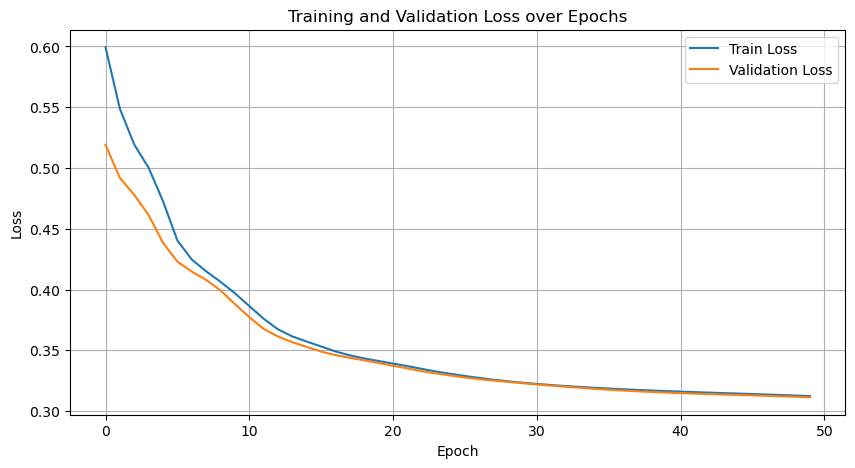

In [ ]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig(FOLDER_MODEL_SAVE+'/loss_plot.png')
plt.show()


# Testing

In [43]:
model.load_state_dict(torch.load(FOLDER_MODEL_SAVE+'/best_model.pth'))
model.to(device)

/tmp/ipykernel_4059456/2880630540.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(FOLDER_MODEL_SAVE+'/best_model.pth'))


SimpleSTConvAE(
  (layers): ModuleList(
    (0): SimpleEncoder(
      (temporal_conv): SimpleTemporalConv(
        (conv1): Conv2d(8, 8, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1))
        (conv2): Conv2d(8, 8, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1))
        (conv3): Conv2d(8, 8, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1))
      )
      (graph_conv): SimpleSpatialConv(
        (conv): ChebConv(8, 16, K=3, normalization=sym)
      )
      (temporal_conv_2): SimpleTemporalConv(
        (conv1): Conv2d(16, 32, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1))
        (conv2): Conv2d(16, 32, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1))
        (conv3): Conv2d(16, 32, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1))
      )
    )
    (1): SimpleDecoder(
      (temporal_deconv): SimpleTemporalDeConv(
        (deconv1): ConvTranspose2d(32, 16, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1))
        (deconv2): ConvTranspose2d(32, 16, kernel_size=(1, 4), str

In [44]:
def detect_anomalies(model, test_loader, criterion, threshold=None, device=device):
    model.eval()
    losses = []

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)  # Move data to device
            output = model(data, edge_index)
            loss = criterion(output, data)
            losses.append(loss.item())

    
    # Se non fornisci un threshold, usiamo ad esempio la media + 2*deviazione standard come soglia
    if threshold is None:
        threshold = np.mean(losses) #+ 1 * np.std(losses)
    
    # Identifica le anomalie
    anomalies = [i for i, loss in enumerate(losses) if loss > threshold]
    
    return losses, threshold, anomalies


In [45]:
# Esegui il rilevamento delle anomalie
test_losses, anomaly_threshold, anomalies  = detect_anomalies(model, test_loader, criterion, threshold=None, device=device)

print(f"Anomaly Threshold: {anomaly_threshold}")
print(f"Detected Anomalies at indices: {anomalies}")

Anomaly Threshold: 0.3317556311102474
Detected Anomalies at indices: [9, 10, 11, 12, 13, 14, 15, 16]


In [46]:
mapping_variables = {
    0 : 'solar_zenith_angle',
    1 : 'solar_azimuth_angle',
    2 : 'surf_air_temp_masked',
    3 : 'surf_temp_masked',
    4 : 'surf_spec_hum_masked',
    5 : 'h2o_vap_tot_masked',
    6 : 'cloud_liquid_water_masked',
    7 : 'atmosphere_mass_content_of_cloud_ice_masked'
}

In [47]:
corruption_level = 0.2
variables = [1, 7]  # Features to corrupt
variables.sort()
FOLDER_CORRUPTION = '_'.join([str(mapping_variables[variable]) for variable in variables])

data_corrupted, indices = load_data(DATA_PATH,'corruption2/'+FOLDER_CORRUPTION, corruption_level)
indices = indices[int((TRAIN_RATIO+VAL_RATIO)*len(data_corrupted)):]
data_corrupted = data_corrupted[int((TRAIN_RATIO+VAL_RATIO)*len(data_corrupted)):]

mixed_loader = DataLoader(data_corrupted, batch_size=TEST_BATCH_SIZE, shuffle=False)

/tmp/ipykernel_4059456/2839598384.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_data = [torch.load(file_path) for file_path in file_paths]  # Ogni file è (num_node

In [48]:
# Detect anomalies in the mixed data
mixed_losses, _, mixed_anomalies = detect_anomalies(model, mixed_loader, criterion, threshold=anomaly_threshold)

print(f"Detected Anomalies in Mixed Data at indices: {mixed_anomalies}")

Detected Anomalies in Mixed Data at indices: [9, 10, 11, 12, 13, 14, 15, 16]


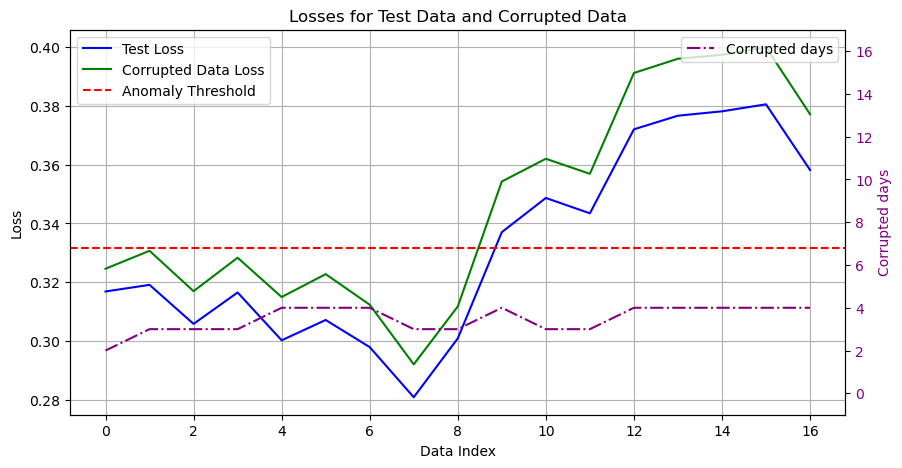

In [49]:
# Plot the losses for the test data and corrupted data with separate axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Primary y-axis for losses
ax1.plot(test_losses, label='Test Loss', color='blue')
ax1.plot(mixed_losses, label='Corrupted Data Loss', color='green')
ax1.axhline(anomaly_threshold, color='red', linestyle='--', label='Anomaly Threshold')
ax1.set_xlabel('Data Index')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.set_title('Losses for Test Data and Corrupted Data')

# Secondary y-axis for indices
ax2 = ax1.twinx()
ax2.plot(indices, label='Corrupted days', color='purple', linestyle='-.')
ax2.set_ylabel('Corrupted days', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.set_ylim(-1, 17)  # Set the range of indices between 0 and 16
ax2.legend(loc='upper right')

# Save the plot
plt.savefig(FOLDER_MODEL_SAVE+'/test_corrupted_losses.png')

# Show the plot
plt.show()


In [50]:
# Define the total number of data points (adjust if needed)
total_data_points = len(test_data)

# Create binary lists for actual and predicted anomalies
actual_anomalies = [1 if i>0 else 0 for i in indices]
predicted_anomalies = [1 if i in mixed_anomalies else 0 for i in range(total_data_points)]

# Calculate the metrics
accuracy = accuracy_score(actual_anomalies, predicted_anomalies)
recall = recall_score(actual_anomalies, predicted_anomalies)
precision = precision_score(actual_anomalies, predicted_anomalies)
f1 = f1_score(actual_anomalies, predicted_anomalies)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

# Save the results
results = {
    'Accuracy': accuracy,
    'Recall': recall,
    'Precision': precision,
    'F1 Score': f1,
}

with open(FOLDER_MODEL_SAVE+'/metrics.json', 'w') as f:
    json.dump(results, f, indent=4)

Accuracy: 0.47058823529411764
Recall: 0.47058823529411764
Precision: 1.0
F1 Score: 0.64


In [51]:
print(classification_report(actual_anomalies, predicted_anomalies, target_names=['Normal', 'Anomaly']))

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         0
     Anomaly       1.00      0.47      0.64        17

    accuracy                           0.47        17
   macro avg       0.50      0.24      0.32        17
weighted avg       1.00      0.47      0.64        17



/home/dl.net/rgiordano/miniconda3/envs/earth_science_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dl.net/rgiordano/miniconda3/envs/earth_science_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dl.net/rgiordano/miniconda3/envs/earth_science_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

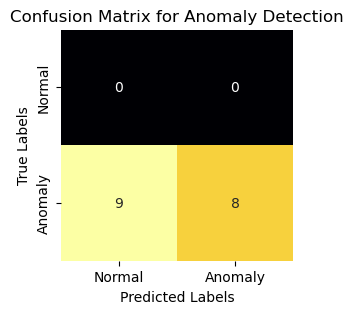

In [52]:
# Plot the confusion matrix
cf = confusion_matrix(actual_anomalies, predicted_anomalies)

plt.figure(figsize=(3,3))
sns.heatmap(cf, annot=True, fmt='d', cmap='inferno', cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Anomaly Detection')

plt.savefig(FOLDER_MODEL_SAVE+'/confusion_matrix.png')

plt.show()

In [ ]:
# Stop here
# raise SystemExit(0)

SystemExit: 0

/home/dl.net/rgiordano/miniconda3/envs/earth_science_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Analysis on different corruption levels
For every couple of variables having an high correlation a different level of corruption is applied. The first is the baseline with a corruption applied to all the variables.

In [84]:
# Feature index pairs to test
correlated_vars = [
# [0, 1],
# [0, 3],
[3],
[2, 3],
# [2, 5],
# [4, 5],
# [0, 1, 3],
# [0, 2, 3]
]

low_correlated_vars = [
# [0, 4],
# [0, 5],
# [0, 6],
# [0, 7],
# [1, 2],
# [1, 4],
# [1, 5],
# [1, 6],
[1, 7],
# [2, 7],
# [3, 6],
# [3, 7],
# [4, 6],
# [4, 7],
# [5, 6],
# [5, 7],
]

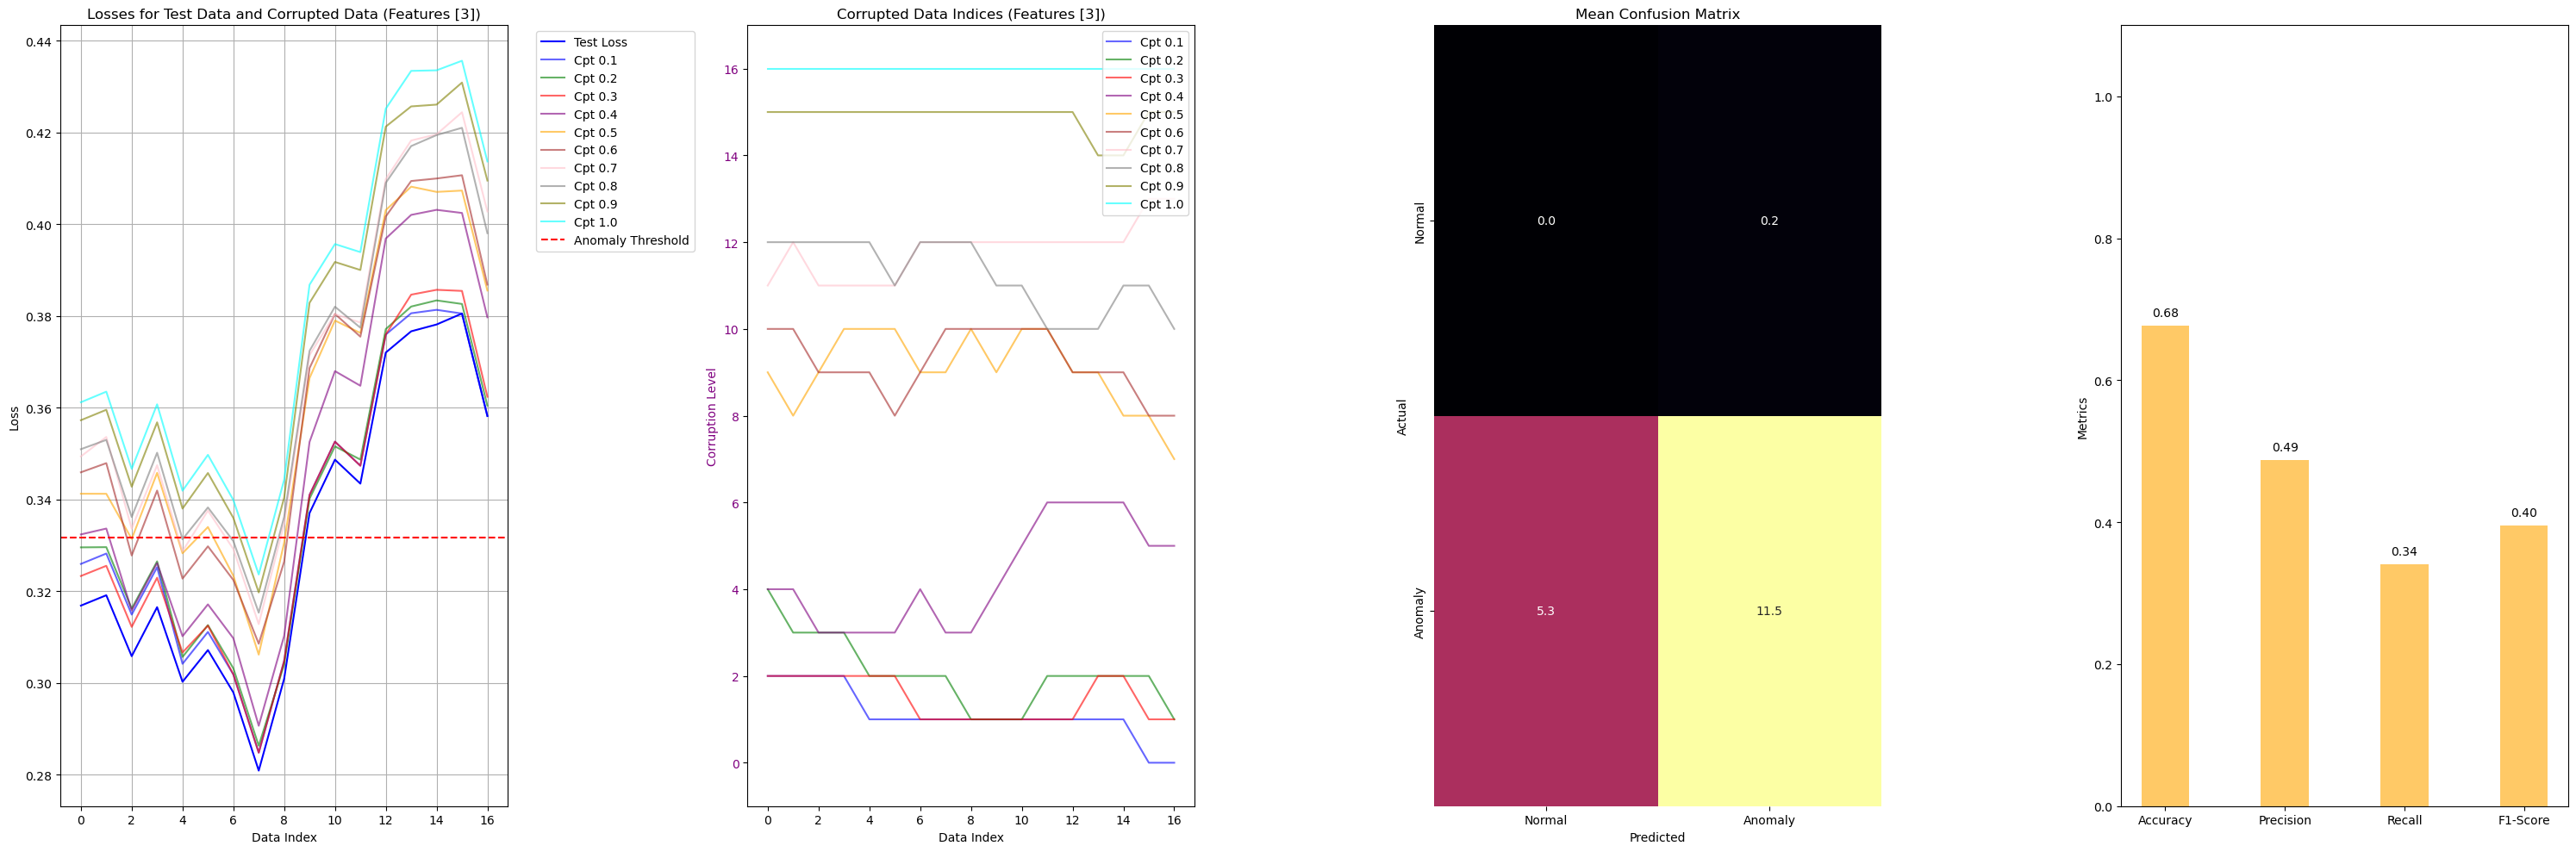

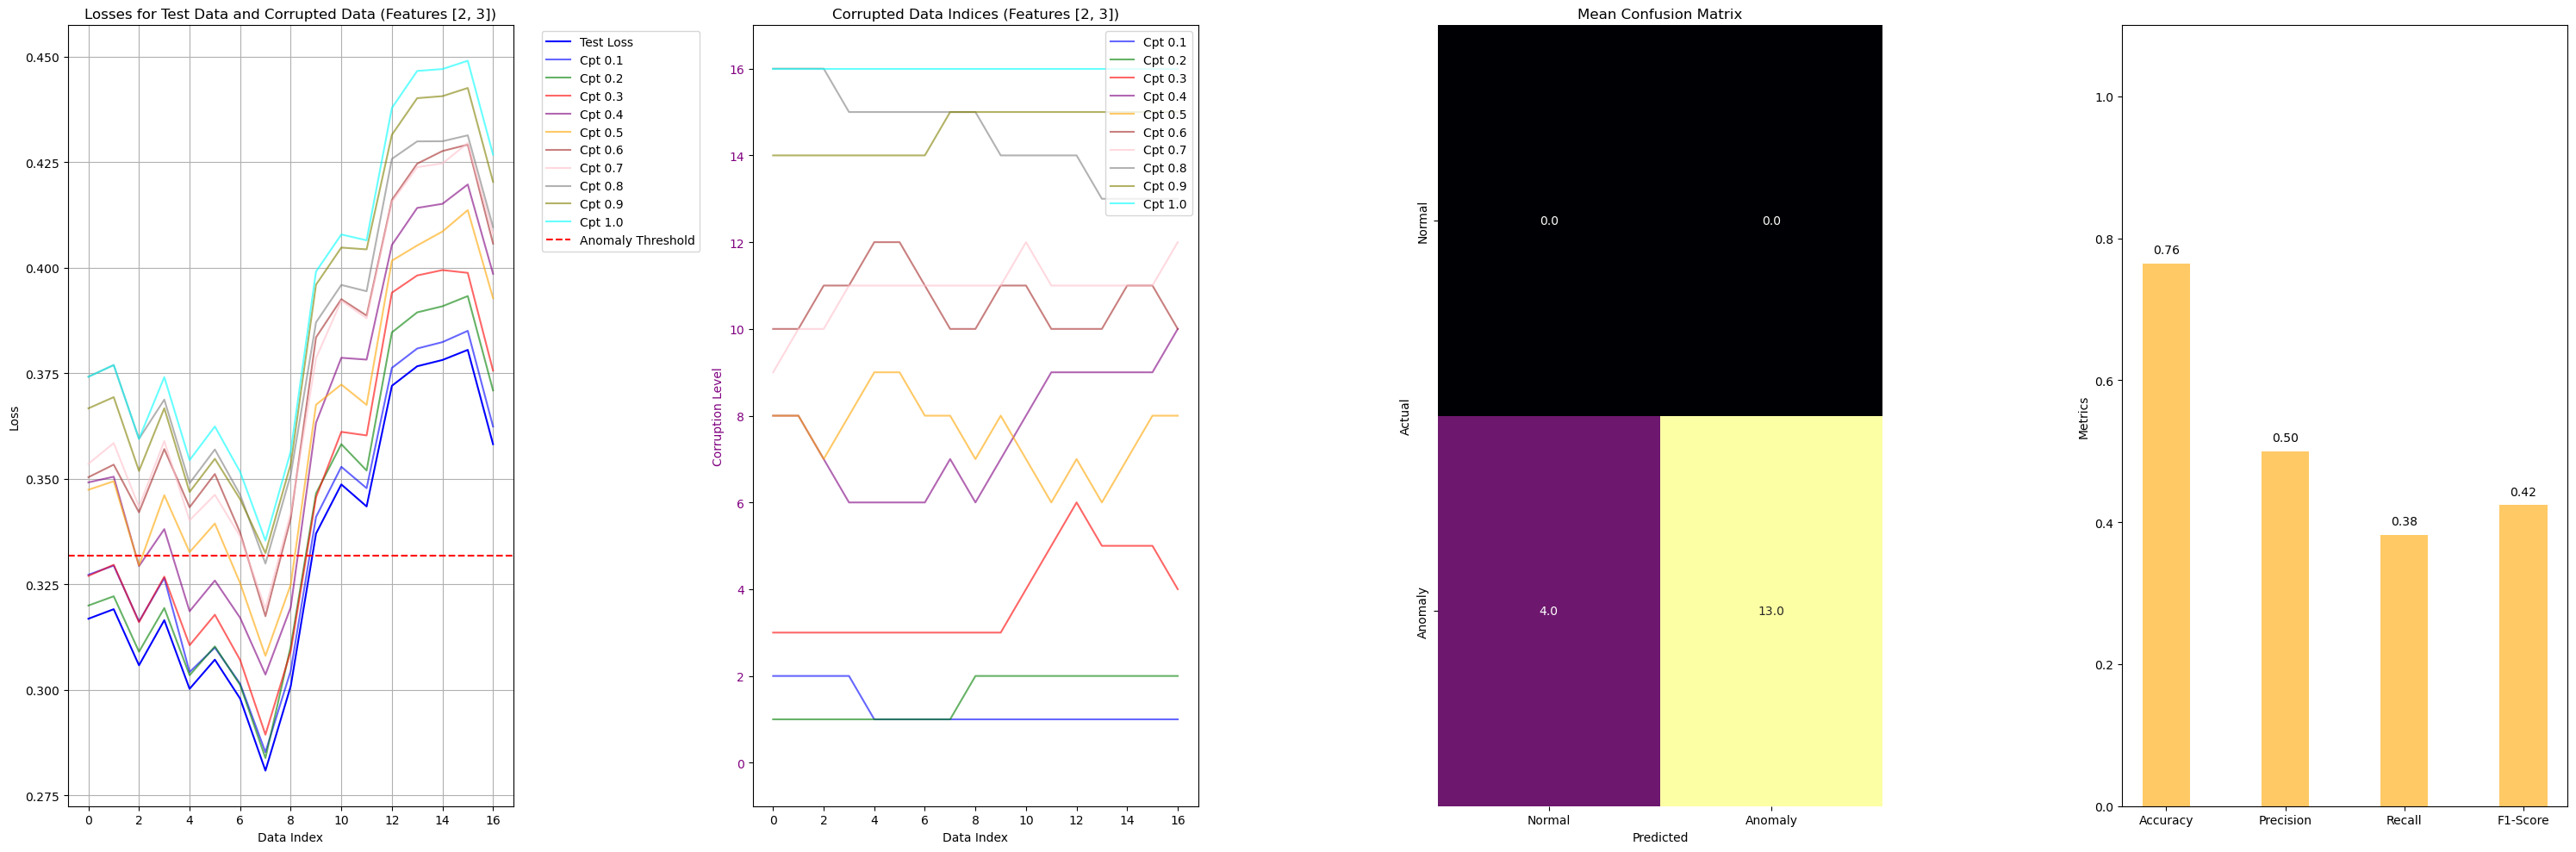

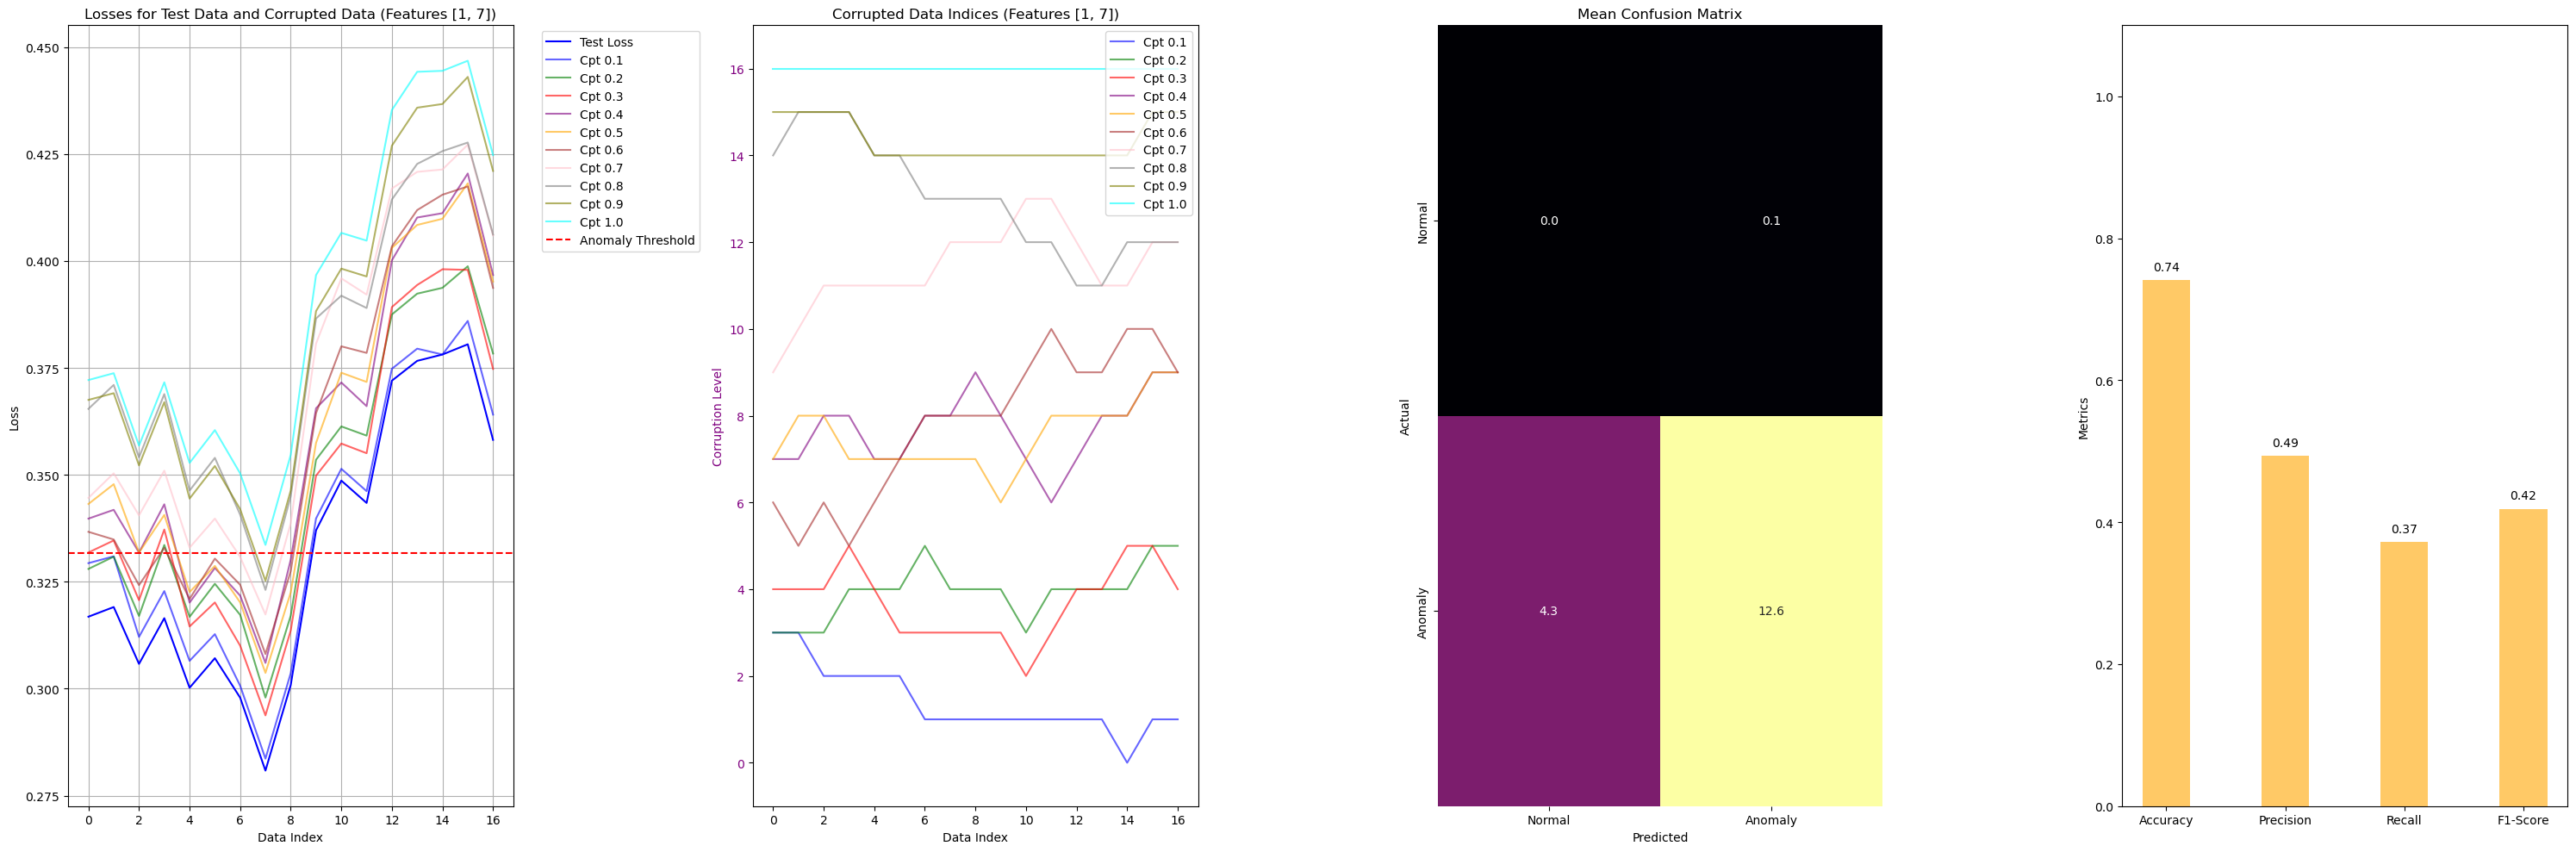

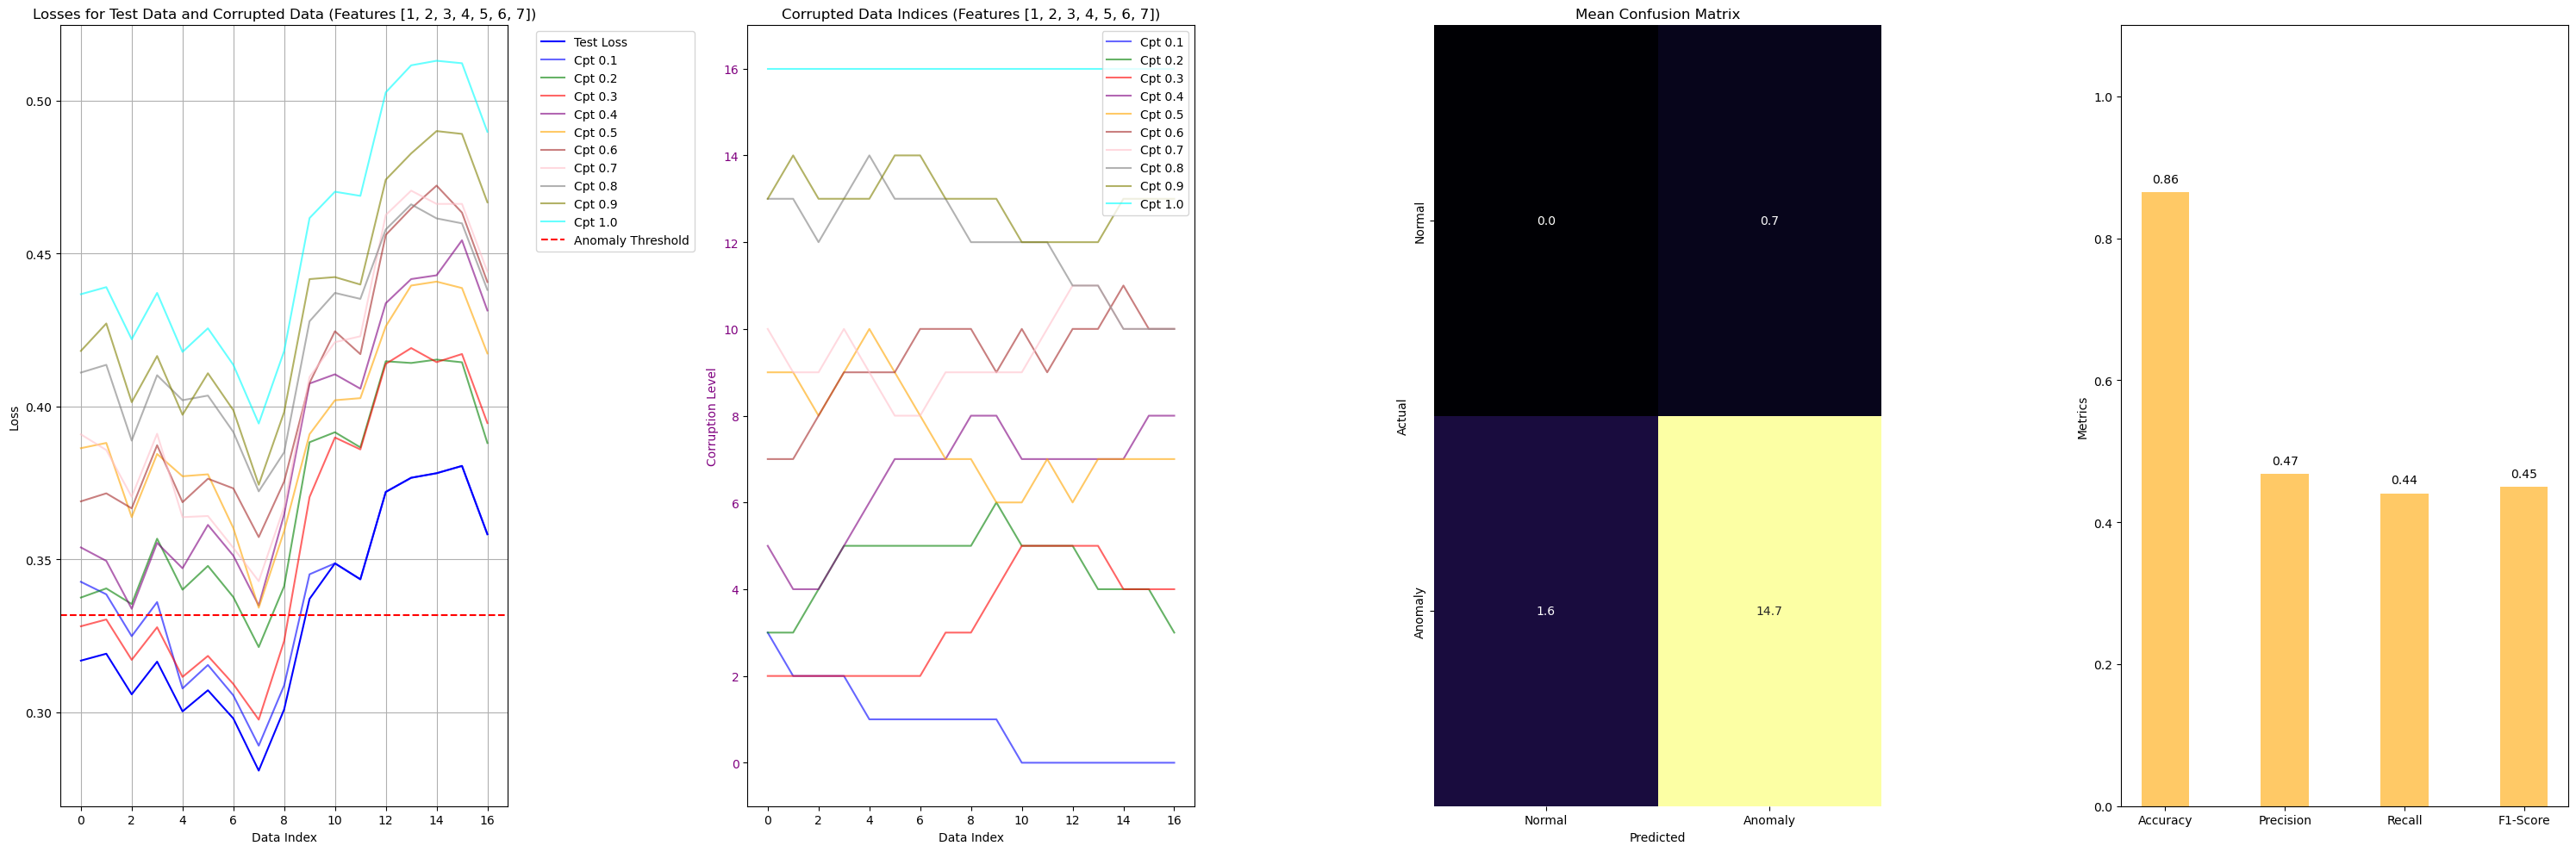

In [85]:
corruption_levels = [i / 10 for i in range(1, 11)]  # Levels from 0.1 to 1.0
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

# Loop through each pair of feature indices
for pair in correlated_vars + low_correlated_vars + [[1, 2, 3, 4, 5, 6, 7]]:
    fig, axes = plt.subplots(1, 4, figsize=(30, 10))  # Three subplots: losses, corrupted data, and metrics

    ax1, ax2, ax3, ax4= axes

    # Original test losses
    ax1.plot(test_losses, label='Test Loss', color='blue')

    mean_class_rep = []
    mean_cm = []

    # Loop through corruption levels
    for corruption_level in corruption_levels:
        # Sort features without modifying the original `pair`
        sorted_pair = sorted(pair)

        # Generate folder corruption name
        FOLDER_CORRUPTION = '_'.join([str(mapping_variables[var]) for var in sorted_pair])

        # Load corrupted data
        data_corrupted, indices = load_data(DATA_PATH, f'corruption2/{FOLDER_CORRUPTION}', corruption_level)
        indices = indices[int((TRAIN_RATIO + VAL_RATIO) * len(data_corrupted)):]
        data_corrupted = data_corrupted[int((TRAIN_RATIO + VAL_RATIO) * len(data_corrupted)):]

        corrupted_loader = DataLoader(data_corrupted, batch_size=TEST_BATCH_SIZE, shuffle=False)

        # Detect anomalies in the corrupted data
        corrupted_losses, _, corrupted_anomalies = detect_anomalies(model, corrupted_loader, criterion, threshold=anomaly_threshold)

        # Plot corrupted losses
        color_idx = min(int(corruption_level * 10) - 1, len(colors) - 1)
        ax1.plot(corrupted_losses, label=f'Cpt {corruption_level:.1f}', alpha=0.6, color=colors[color_idx])
        ax2.plot(indices, alpha=0.6, label=f'Cpt {corruption_level:.1f}', color=colors[color_idx])

        # Metrics calculations
        actual_anomalies = [1 if i > 0 else 0 for i in indices]
        predicted_anomalies = [1 if i in corrupted_anomalies else 0 for i in range(len(indices))]

        # Classification report and confusion matrix
        class_rep = classification_report(actual_anomalies, predicted_anomalies, target_names=['Normal', 'Anomaly'], output_dict=True, labels=[0, 1])
        cm = confusion_matrix(actual_anomalies, predicted_anomalies, labels=[0, 1])

        mean_class_rep.append(class_rep)
        mean_cm.append(cm)
  
    # Calculate mean metrics
    mean_cm = np.mean(mean_cm, axis=0)

    mean_accuracy = np.mean([rep['accuracy'] for rep in mean_class_rep])

    # Prepare metrics for the bar plot
    mean_class_rep = {
        metric: np.mean([rep['macro avg'][metric] for rep in mean_class_rep])
        for metric in ['precision', 'recall', 'f1-score']
    }

    

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metric_values = [mean_accuracy] + [mean_class_rep[m] for m in ['precision', 'recall', 'f1-score']]

    # Plot mean confusion matrix as heatmap
    sns.heatmap(mean_cm, annot=True, fmt='.1f', cmap='inferno', cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'], ax=ax3)
    ax3.set_title('Mean Confusion Matrix')
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('Actual')
    
    # Add bar plot to the same subplot
    ax4.bar(metrics, metric_values, alpha=0.6, color='orange', width=0.4)
    ax4.set_ylim(0, 1.1)
    ax4.set_ylabel('Metrics')
    
    # Print the legend with the values in ax4
    for i, v in enumerate(metric_values):
        ax4.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

    # Plot threshold and titles
    ax1.axhline(anomaly_threshold, color='red', linestyle='--', label='Anomaly Threshold')
    ax1.set_xlabel('Data Index')
    ax1.set_ylabel('Loss')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True)
    ax1.set_title(f'Losses for Test Data and Corrupted Data (Features {pair})')

    # Secondary plot: corrupted indices
    ax2.set_ylabel('Corruption Level', color='purple')
    ax2.tick_params(axis='y', labelcolor='purple')
    ax2.set_ylim(-1, 17)
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Data Index')
    ax2.set_title(f'Corrupted Data Indices (Features {pair})')

    plt.tight_layout()

    plt.savefig(FOLDER_MODEL_SAVE + f'/corrupted_losses_{FOLDER_CORRUPTION}.png')
    
    plt.show()


### Analysis on different treshold levels fixing a corruption to 0.3

In [ ]:
# Set fixed corruption level
fixed_corruption_level = 0.3
threshold_levels = [i / 10 for i in range(11)]  # Thresholds from 0.0 to 1.0
feature_index_pairs = [[1, 3], [2, 3], [2, 4], [2, 5], [3, 5], [4, 5]]

# Store results for each feature pair and threshold level
results = []

# Loop through each pair of feature indices
for pair in feature_index_pairs:
    # Corrupt the data at the fixed corruption level with selected features
    corrupted_data = [
        Data(
            x=corrupt_data(data, fixed_corruption_level, pair),
            edge_index=data.edge_index
        ) for data in test_data
    ]
    corrupted_loader = DataLoader(corrupted_data, batch_size=TEST_BATCH_SIZE, shuffle=False)
    
    # Get true labels (1 for anomaly in corrupted data, 0 for normal in test data)
    true_labels = [1 if i in corrupted_anomalies else 0 for i in range(len(test_data))]
    
    # Loop through each threshold level
    for threshold in threshold_levels:
        # Detect anomalies at the current threshold
        _, _, detected_anomalies = detect_anomalies(model, corrupted_loader, loss_fn, threshold=threshold)
        
        # Create predicted labels (1 for detected anomaly, 0 otherwise)
        predicted_labels = [1 if i in detected_anomalies else 0 for i in range(len(test_data))]
        
        # Calculate confusion matrix and metrics
        cm = confusion_matrix(true_labels, predicted_labels)
        if cm.shape == (1, 1):
            # Only one class is present in true or predicted labels
            if true_labels[0] == 1:  # All are positives
                tn, fp, fn, tp = 0, 0, 0, cm[0, 0]
            else:  # All are negatives
                tn, fp, fn, tp = cm[0, 0], 0, 0, 0
        elif cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            # Unexpected shape, skip this iteration
            continue
        
        accuracy = accuracy_score(true_labels, predicted_labels)
        recall = recall_score(true_labels, predicted_labels, zero_division=1)
        precision = precision_score(true_labels, predicted_labels, zero_division=1)
        f1 = f1_score(true_labels, predicted_labels, zero_division=1)
        
        # Store the metrics
        results.append({
            'Feature Pair': str(pair),
            'Threshold': threshold,
            'True Positives': tp,
            'False Positives': fp,
            'True Negatives': tn,
            'False Negatives': fn,
            'Accuracy': accuracy,
            'Recall': recall,
            'Precision': precision,
            'F1 Score': f1
        })

/home/dl.net/rgiordano/miniconda3/envs/earth_science_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/dl.net/rgiordano/miniconda3/envs/earth_science_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/dl.net/rgiordano/miniconda3/envs/earth_science_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/dl.net/rgiordano/miniconda3/envs/earth_science_env/lib/python

In [ ]:
# Display results in a DataFrame
results_df = pd.DataFrame(results)
display(results_df)

,Feature Pair,Threshold,True Positives,False Positives,True Negatives,False Negatives,Accuracy,Recall,Precision,F1 Score
0,"[1, 3]",0.0,19,0,0,0,1.000000,1.000000,1.0,1.000000
1,"[1, 3]",0.1,19,0,0,0,1.000000,1.000000,1.0,1.000000
2,"[1, 3]",0.2,19,0,0,0,1.000000,1.000000,1.0,1.000000
3,"[1, 3]",0.3,19,0,0,0,1.000000,1.000000,1.0,1.000000
4,"[1, 3]",0.4,19,0,0,0,1.000000,1.000000,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...
61,"[4, 5]",0.6,9,0,0,10,0.473684,0.473684,1.0,0.642857
62,"[4, 5]",0.7,4,0,0,15,0.210526,0.210526,1.0,0.347826
63,"[4, 5]",0.8,1,0,0,18,0.052632,0.052632,1.0,0.100000
64,"[4, 5]",0.9,0,0,0,19,0.000000,0.000000,1.0,0.000000


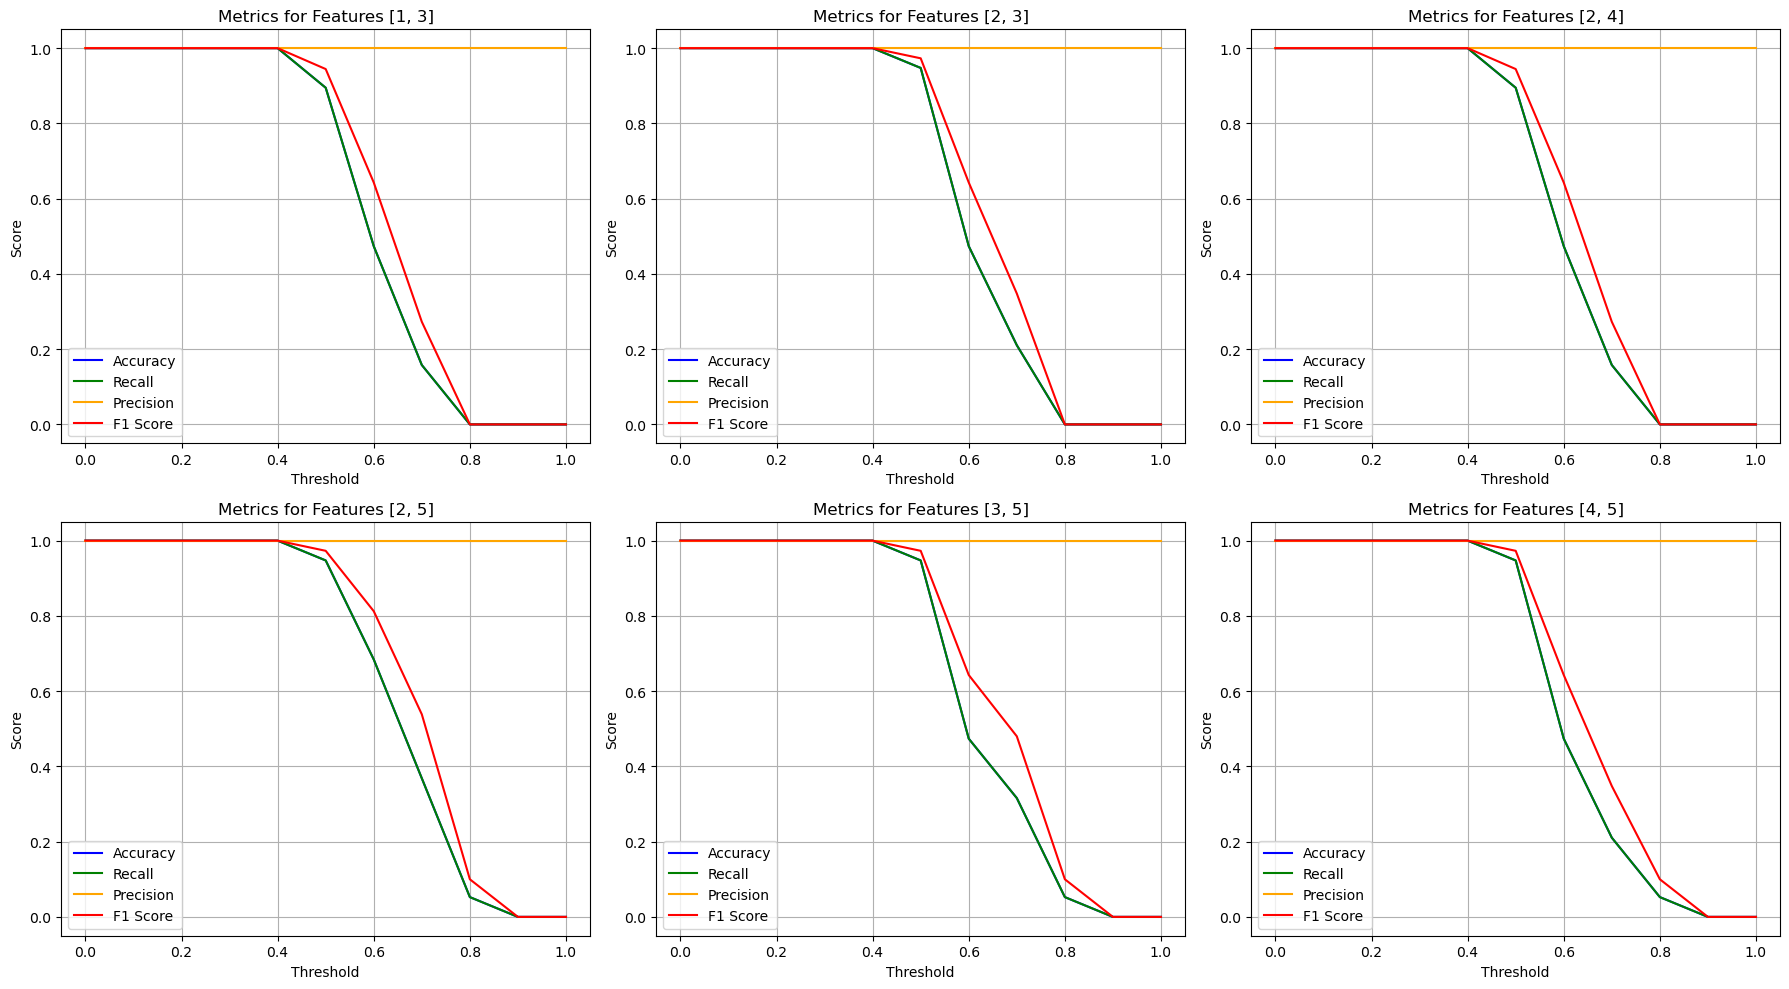

In [ ]:
#plot the results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, pair in enumerate(feature_index_pairs):
    pair_results = results_df[results_df['Feature Pair'] == str(pair)]
    
    axes[i].plot(pair_results['Threshold'], pair_results['Accuracy'], label='Accuracy', color='blue')
    axes[i].plot(pair_results['Threshold'], pair_results['Recall'], label='Recall', color='green')
    axes[i].plot(pair_results['Threshold'], pair_results['Precision'], label='Precision', color='orange')
    axes[i].plot(pair_results['Threshold'], pair_results['F1 Score'], label='F1 Score', color='red')
    
    axes[i].set_title(f'Metrics for Features {pair}')
    axes[i].set_xlabel('Threshold')
    axes[i].set_ylabel('Score')
    axes[i].legend()
    axes[i].grid(True)
    
plt.tight_layout()
plt.show()